Generated dataset: (960, 9)
Saved CSV: /content/project1_output/virtual_doe_data.csv

Model performance on held-out test set:
R2  = 0.918
MAE = 5.73 Yield_%
Saved model: /content/project1_output/yield_model.pkl


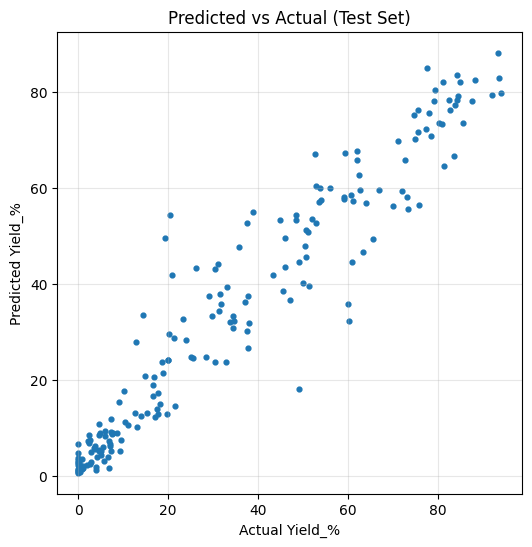


Top 12 features by permutation importance:
       feature  importance_mean  importance_std
Pressure_mTorr         0.710347        0.064145
    RF_power_W         0.575502        0.035612
        Temp_C         0.551691        0.050578
  GasFlow_sccm         0.019187        0.003334
        Bias_V         0.009207        0.002557
        Time_s         0.004162        0.001240
RecipeFamily_C         0.001202        0.000540
RecipeFamily_A         0.000913        0.000594
RecipeFamily_B         0.000212        0.000369


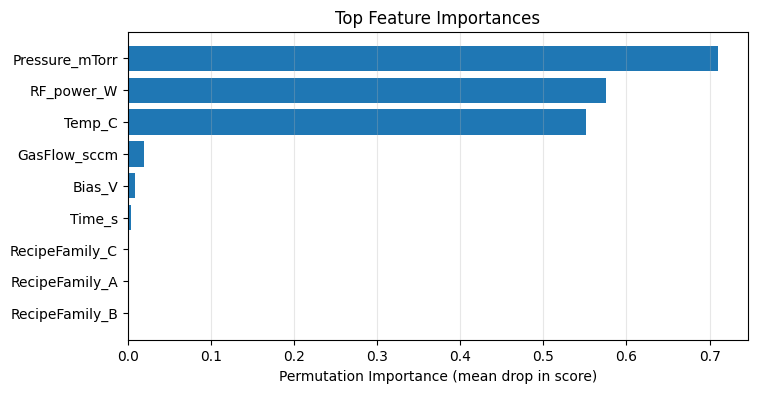


Best recipe found (by predicted yield):
  RecipeFamily: B
  RF_power_W: 719.890
  Bias_V: 275.932
  Pressure_mTorr: 25.106
  GasFlow_sccm: 333.884
  Temp_C: 75.903
  Time_s: 50.505
  Predicted_Yield_%: 89.045
Saved best recipe: /content/project1_output/best_recipe.json
Saved top 50 recipes: /content/project1_output/top50_recipes.csv

Outputs saved in: /content/project1_output
 - virtual_doe_data.csv
 - yield_model.pkl
 - best_recipe.json
 - top50_recipes.csv


In [2]:
# ============================================================
# Project 1 — Virtual DOE Lab: Yield vs Process Window Optimizer (Colab-ready)
# What it does:
# 1) Generates a synthetic DOE dataset (900–1000 rows) and saves as CSV
# 2) Trains an ML regression model to predict Yield_% from process knobs
# 3) Evaluates model (R2 / MAE) and shows feature importance
# 4) Finds the "best recipe" (process settings) by constrained random search
# 5) Saves trained model + best recipe + predictions
#
# Run: Paste this entire cell into Google Colab and execute.
# ============================================================

!pip -q install pandas numpy scikit-learn joblib matplotlib

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import joblib

# ----------------------------
# 1) Settings
# ----------------------------
OUT_DIR = "/content/project1_output"
os.makedirs(OUT_DIR, exist_ok=True)

N_ROWS = 960  # keep between 900-1000
SEED = 7
rng = np.random.default_rng(SEED)

# Process knobs (features) + realistic ranges
RANGES = {
    "RF_power_W": (200, 900),          # W
    "Bias_V": (0, 450),                # V
    "Pressure_mTorr": (5, 60),         # mTorr
    "GasFlow_sccm": (50, 400),         # sccm
    "Temp_C": (20, 140),               # C
    "Time_s": (10, 120),               # seconds
}

# Optional categorical factor (recipe family)
RECIPE_FAMILIES = ["A", "B", "C"]


# ----------------------------
# 2) Synthetic DOE dataset generator
# ----------------------------
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

def make_synthetic_yield(df: pd.DataFrame, noise_std: float = 2.0) -> np.ndarray:
    """
    Create a nonlinear yield surface with interactions and mild recipe-family offsets.
    This is engineered so ML has real structure to learn.
    """
    rf = df["RF_power_W"].to_numpy()
    bias = df["Bias_V"].to_numpy()
    p = df["Pressure_mTorr"].to_numpy()
    flow = df["GasFlow_sccm"].to_numpy()
    tC = df["Temp_C"].to_numpy()
    time = df["Time_s"].to_numpy()

    # "Sweet spots" (centers) and penalties
    # - Yield drops if pressure too high/low, temp too high, etc.
    p_pen = ((p - 25) / 15)**2
    t_pen = ((tC - 90) / 30)**2
    rf_pen = ((rf - 650) / 180)**2
    bias_pen = ((bias - 250) / 170)**2
    flow_pen = ((flow - 220) / 120)**2
    time_pen = ((time - 70) / 35)**2

    # Interaction: high RF + high bias can harm yield (charging / damage proxy)
    interaction_damage = ((rf / 900) * (bias / 450))**1.6

    # Interaction: moderate flow helps at moderate pressure
    interaction_process = np.exp(-((p - 25)/18)**2) * (flow/400)

    # Base yield score (latent)
    latent = (
        2.8
        - 0.9 * p_pen
        - 0.8 * t_pen
        - 0.7 * rf_pen
        - 0.5 * bias_pen
        - 0.4 * flow_pen
        - 0.3 * time_pen
        - 0.9 * interaction_damage
        + 0.9 * interaction_process
    )

    # Recipe family offsets (systematic tool-to-tool / recipe-to-recipe effect)
    fam = df["RecipeFamily"].to_numpy()
    fam_offset = np.where(fam == "A", 0.10, np.where(fam == "B", 0.00, -0.08))
    latent = latent + fam_offset

    # Convert to % yield with saturation; add noise
    y = 100 * sigmoid(latent) + rng.normal(0, noise_std, size=len(df))

    # Clip to [0, 100]
    return np.clip(y, 0, 100)

def generate_doe_dataset(n_rows: int = 960) -> pd.DataFrame:
    data = {}
    for k, (lo, hi) in RANGES.items():
        data[k] = rng.uniform(lo, hi, size=n_rows)

    df = pd.DataFrame(data)
    df["RecipeFamily"] = rng.choice(RECIPE_FAMILIES, size=n_rows, replace=True)

    # Create yield
    df["Yield_%"] = make_synthetic_yield(df, noise_std=2.2).round(2)

    # Add an ID column for realism
    df.insert(0, "run_id", [f"DOE_{i+1:04d}" for i in range(n_rows)])

    return df

df = generate_doe_dataset(N_ROWS)
csv_path = os.path.join(OUT_DIR, "virtual_doe_data.csv")
df.to_csv(csv_path, index=False)

print("Generated dataset:", df.shape)
print("Saved CSV:", csv_path)
df.head()


# ----------------------------
# 3) Train ML regression model
# ----------------------------
# One-hot encode categorical feature
X = df.drop(columns=["Yield_%", "run_id"]) # FIX: Drop 'run_id' column as it's not a numerical feature
y = df["Yield_%"].astype(float)

X_encoded = pd.get_dummies(X, columns=["RecipeFamily"], drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=SEED
)

# RandomForest: strong non-linear baseline, fast, no scaling needed
model = RandomForestRegressor(
    n_estimators=400,
    random_state=SEED,
    n_jobs=-1,
    min_samples_leaf=2
)
model.fit(X_train, y_train)

pred_test = model.predict(X_test)

r2 = r2_score(y_test, pred_test)
mae = mean_absolute_error(y_test, pred_test)

print(f"\nModel performance on held-out test set:")
print(f"R2  = {r2:.3f}")
print(f"MAE = {mae:.2f} Yield_%")

# Save model
model_path = os.path.join(OUT_DIR, "yield_model.pkl")
joblib.dump(model, model_path)
print("Saved model:", model_path)


# ----------------------------
# 4) Plots: Pred vs Actual
# ----------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred_test, s=12)
plt.xlabel("Actual Yield_%")
plt.ylabel("Predicted Yield_%")
plt.title("Predicted vs Actual (Test Set)")
plt.grid(True, alpha=0.3)
plt.show()

# ----------------------------
# 5) Feature importance (Permutation Importance)
# ----------------------------
# Permutation importance is slower than built-in RF importance but more reliable.
# We'll run it on a small sample to keep it quick.
sample_idx = rng.choice(len(X_test), size=min(250, len(X_test)), replace=False)
perm = permutation_importance(
    model, X_test.iloc[sample_idx], y_test.iloc[sample_idx],
    n_repeats=10, random_state=SEED, n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

print("\nTop 12 features by permutation importance:")
print(imp.head(12).to_string(index=False))

plt.figure(figsize=(8, 4))
topk = imp.head(12).iloc[::-1]
plt.barh(topk["feature"], topk["importance_mean"])
plt.xlabel("Permutation Importance (mean drop in score)")
plt.title("Top Feature Importances")
plt.grid(True, axis="x", alpha=0.3)
plt.show()


# ----------------------------
# 6) Best recipe search (constrained random search)
# ----------------------------
def sample_candidate_recipes(n: int = 30000) -> pd.DataFrame:
    """Generate candidate recipes inside the same ranges."""
    cand = {}
    for k, (lo, hi) in RANGES.items():
        cand[k] = rng.uniform(lo, hi, size=n)
    cand["RecipeFamily"] = rng.choice(RECIPE_FAMILIES, size=n)
    # run_id not needed for candidates
    return pd.DataFrame(cand)

# Optional constraint examples (edit as needed)
# e.g., limit RF power and temp to reduce risk/cost; keep pressure in a narrower window.
def apply_constraints(cand: pd.DataFrame) -> pd.DataFrame:
    return cand[
        (cand["RF_power_W"] <= 850) &
        (cand["Temp_C"] <= 125) &
        (cand["Pressure_mTorr"] >= 8) & (cand["Pressure_mTorr"] <= 50) &
        (cand["Time_s"] >= 20) & (cand["Time_s"] <= 110)
    ].copy()

candidates = sample_candidate_recipes(n=40000)
candidates = apply_constraints(candidates)

# Encode candidates
cand_encoded = pd.get_dummies(candidates, columns=["RecipeFamily"], drop_first=False)

# Ensure same column order as training
for col in X_encoded.columns:
    if col not in cand_encoded.columns:
        cand_encoded[col] = 0
cand_encoded = cand_encoded[X_encoded.columns]

candidates["Predicted_Yield_%"] = model.predict(cand_encoded)

best_idx = candidates["Predicted_Yield_%"].idxmax()
best_recipe = candidates.loc[best_idx].to_dict()

print("\nBest recipe found (by predicted yield):")
for k in ["RecipeFamily"] + list(RANGES.keys()) + ["Predicted_Yield_%"]:
    if k in best_recipe:
        print(f"  {k}: {best_recipe[k]:.3f}" if isinstance(best_recipe[k], (float, np.floating)) else f"  {k}: {best_recipe[k]}")

# Save best recipe
best_recipe_path = os.path.join(OUT_DIR, "best_recipe.json")
with open(best_recipe_path, "w") as f:
    json.dump(best_recipe, f, indent=2)
print("Saved best recipe:", best_recipe_path)

# Save candidate leaderboard (top 50)
top50 = candidates.sort_values("Predicted_Yield_%", ascending=False).head(50)
top50_path = os.path.join(OUT_DIR, "top50_recipes.csv")
top50.to_csv(top50_path, index=False)
print("Saved top 50 recipes:", top50_path)

# ----------------------------
# 7) Print where outputs are
# ----------------------------
print("\nOutputs saved in:", OUT_DIR)
print(" - virtual_doe_data.csv")
print(" - yield_model.pkl")
print(" - best_recipe.json")
print(" - top50_recipes.csv")